In [1]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline


##  Step 1: Loading and Inspecting the Dataset

In [2]:
# Load the dataset
data = pd.read_csv('salaries.csv')

# Display the first few rows of the dataset to inspect its contents
data.head()


,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2024,MI,FT,Data Scientist,120000,USD,120000,AU,0,AU,S
1,2024,MI,FT,Data Scientist,70000,USD,70000,AU,0,AU,S
2,2024,MI,CT,Data Scientist,130000,USD,130000,US,0,US,M
3,2024,MI,CT,Data Scientist,110000,USD,110000,US,0,US,M
4,2024,MI,FT,Data Science Manager,240000,USD,240000,US,0,US,M


In [3]:
data.shape

(16494, 11)

## Step 2: Handling Missing Values

In [4]:
round(data.isnull().mean()*100,2) 

work_year             0.0
experience_level      0.0
employment_type       0.0
job_title             0.0
salary                0.0
salary_currency       0.0
salary_in_usd         0.0
employee_residence    0.0
remote_ratio          0.0
company_location      0.0
company_size          0.0
dtype: float64

In [5]:
data['remote_ratio'].value_counts()

0      11084
100     5161
50       249
Name: remote_ratio, dtype: int64

In [6]:
data['experience_level'].value_counts()

SE    10652
MI     4024
EN     1319
EX      499
Name: experience_level, dtype: int64

In [7]:
data['work_year'].value_counts()

2023    8519
2024    6027
2022    1655
2021     218
2020      75
Name: work_year, dtype: int64

In [8]:
data['employment_type'].value_counts()

FT    16414
PT       38
CT       28
FL       14
Name: employment_type, dtype: int64

In [9]:
data['company_size'].value_counts()

M    15268
L     1038
S      188
Name: company_size, dtype: int64

In [10]:
data['company_location'].value_counts()

US    14478
GB      694
CA      455
ES      133
DE      105
      ...  
AM        1
QA        1
AD        1
EC        1
MD        1
Name: company_location, Length: 77, dtype: int64

In [11]:
# Group 'company_location' values by their counts
location_counts = data['company_location'].value_counts()

# Identify locations with counts less than 400
locations_to_group = location_counts[location_counts < 400].index

# Replace these locations with "Other"
data['company_location'] = data['company_location'].apply(
    lambda x: 'Other' if x in locations_to_group else x
)

# Verify the changes
print(data['company_location'].value_counts())


US       14478
Other      867
GB         694
CA         455
Name: company_location, dtype: int64


In [12]:
data['job_title'].value_counts()

Data Engineer                    3456
Data Scientist                   3312
Data Analyst                     2428
Machine Learning Engineer        1703
Research Scientist                529
                                 ... 
Quantitative Research Analyst       1
AWS Data Architect                  1
Analytics Engineering Manager       1
Marketing Data Scientist            1
Data Analytics Associate            1
Name: job_title, Length: 155, dtype: int64

In [13]:
# Group 'job_title' values by their counts
job_title_counts = data['job_title'].value_counts()

# Identify job titles with counts less than 500
titles_to_group = job_title_counts[job_title_counts < 500].index

# Replace these job titles with "Other"
data['job_title'] = data['job_title'].apply(
    lambda x: 'Other' if x in titles_to_group else x
)

# Verify the changes
print(data['job_title'].value_counts())


Other                        5066
Data Engineer                3456
Data Scientist               3312
Data Analyst                 2428
Machine Learning Engineer    1703
Research Scientist            529
Name: job_title, dtype: int64


In [14]:
data.drop(columns=['salary','employee_residence','salary_currency'], inplace=True)

##  Step 3: Encoding Categorical Variables

In [15]:
#1. Ordinal Encoding (Preferred for Meaningful Order)
#If company_size has a natural order (e.g., Small < Medium < Large), ordinal encoding is appropriate.
#Assign numerical values to the categories

size_mapping = {'S': 1, 'M': 2, 'L': 3}
data['company_size'] = data['company_size'].map(size_mapping)


In [16]:
# One-Hot Encoding (Most Common for Employment Type)
#If there’s no meaningful order between types:
data = pd.get_dummies(data, columns=['employment_type'], drop_first=True)


In [17]:
# Ordinal Encoding 'experience_level'
#If the levels represent a natural progression (e.g., EN < MI < SE < EX), ordinal encoding is a great choice:


experience_mapping = {'EN': 1, 'MI': 2, 'SE': 3, 'EX': 4}
data['experience_level'] = data['experience_level'].map(experience_mapping)


In [18]:
# One-hot encode the 'job_title' column
data = pd.get_dummies(data, columns=['job_title'], drop_first=True)


In [19]:
# One-hot encode the 'company_location' column
data = pd.get_dummies(data, columns=['company_location'], drop_first=True)


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16494 entries, 0 to 16493
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype
---  ------                               --------------  -----
 0   work_year                            16494 non-null  int64
 1   experience_level                     16494 non-null  int64
 2   salary_in_usd                        16494 non-null  int64
 3   remote_ratio                         16494 non-null  int64
 4   company_size                         16494 non-null  int64
 5   employment_type_FL                   16494 non-null  uint8
 6   employment_type_FT                   16494 non-null  uint8
 7   employment_type_PT                   16494 non-null  uint8
 8   job_title_Data Engineer              16494 non-null  uint8
 9   job_title_Data Scientist             16494 non-null  uint8
 10  job_title_Machine Learning Engineer  16494 non-null  uint8
 11  job_title_Other                      16494 non-null  u

## Step 4: Splitting Features and Target

In [21]:
# Split the data into features (X) and target (y)
X = data.drop('salary_in_usd', axis=1)
y = data['salary_in_usd']

# Check the shapes of X and y
print(X.shape, y.shape)


(16494, 15) (16494,)


## Step 5: Train-Test Split

In [22]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (e.g., 80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the resulting datasets
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(13195, 15) (3299, 15) (13195,) (3299,)


## Step 6: Feature Scaling (Optional)

In [23]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = scaler.fit_transform(X_train)

# Transform the testing data as well
X_test_scaled = scaler.transform(X_test)


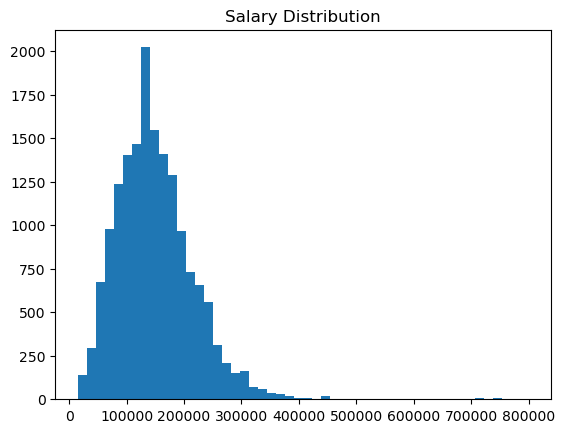

In [24]:
import matplotlib.pyplot as plt

# Plot histogram of salary_in_usd to check for outliers
plt.hist(data['salary_in_usd'], bins=50)
plt.title("Salary Distribution")
plt.show()


In [25]:
# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = data['salary_in_usd'].quantile(0.25)
Q3 = data['salary_in_usd'].quantile(0.75)

# Calculate the Interquartile Range (IQR)
IQR = Q3 - Q1

# Define the outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f"Lower Bound: {lower_bound}, Upper Bound: {upper_bound}")

# Option 1: Remove outliers
data_no_outliers = data[(data['salary_in_usd'] >= lower_bound) & (data['salary_in_usd'] <= upper_bound)]

# Option 2: Cap outliers
data_capped = data.copy()
data_capped['salary_in_usd'] = data_capped['salary_in_usd'].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))

# Print shape of the data after outlier treatment
print("Original data shape:", data.shape)
print("Data shape after removing outliers:", data_no_outliers.shape)
print("Data shape after capping outliers:", data_capped.shape)

Lower Bound: -25056.25, Upper Bound: 312473.75
Original data shape: (16494, 16)
Data shape after removing outliers: (16210, 16)
Data shape after capping outliers: (16494, 16)


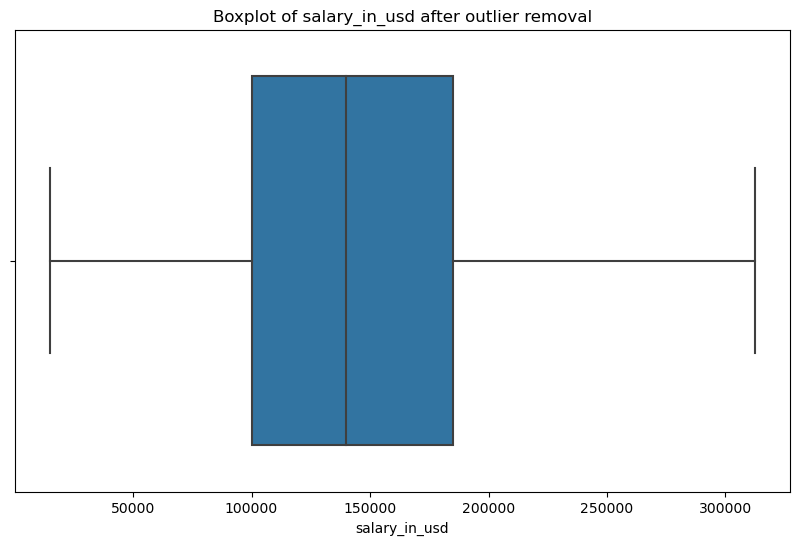

In [26]:
# Visualize salary_in_usd after outlier removal or capping
plt.figure(figsize=(10, 6))
sns.boxplot(x=data_no_outliers['salary_in_usd'])
plt.title('Boxplot of salary_in_usd after outlier removal')
plt.show()


## Step 7: Model Selection and Training

In [27]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16494 entries, 0 to 16493
Data columns (total 16 columns):
 #   Column                               Non-Null Count  Dtype
---  ------                               --------------  -----
 0   work_year                            16494 non-null  int64
 1   experience_level                     16494 non-null  int64
 2   salary_in_usd                        16494 non-null  int64
 3   remote_ratio                         16494 non-null  int64
 4   company_size                         16494 non-null  int64
 5   employment_type_FL                   16494 non-null  uint8
 6   employment_type_FT                   16494 non-null  uint8
 7   employment_type_PT                   16494 non-null  uint8
 8   job_title_Data Engineer              16494 non-null  uint8
 9   job_title_Data Scientist             16494 non-null  uint8
 10  job_title_Machine Learning Engineer  16494 non-null  uint8
 11  job_title_Other                      16494 non-null  u

In [28]:
#  Define and evaluate models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(),
    'Decision Tree': DecisionTreeRegressor(),
    'Support Vector Regressor (SVR)': SVR(),
    'XGBoost': XGBRegressor()
}

model_rmse = {}

for name, model in models.items():
    print(f"Training and evaluating {name}...")
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    rmse = np.sqrt(-cv_scores.mean())
    model_rmse[name] = rmse

# Display RMSE for each model
print("\nRMSE for each model:")
for name, rmse in model_rmse.items():
    print(f"{name}: {rmse}")



Training and evaluating Linear Regression...
Training and evaluating Random Forest...
Training and evaluating Decision Tree...
Training and evaluating Support Vector Regressor (SVR)...
Training and evaluating XGBoost...

RMSE for each model:
Linear Regression: 58391.87986083363
Random Forest: 58525.895988594544
Decision Tree: 59037.81449049803
Support Vector Regressor (SVR): 68702.93970028775
XGBoost: 58481.14844540498


In [29]:
from sklearn.metrics import r2_score

# Dictionary to store R² for each model
model_r2 = {}

for name, model in models.items():
    # Train the model on the training data
    model.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = model.predict(X_test)
    
    # Calculate R² score
    r2 = r2_score(y_test, y_pred)
    
    # Store the R² for comparison
    model_r2[name] = r2

# Display R² for each model
print("\nR² score for each model:")
for name, r2 in model_r2.items():
    print(f"{name}: {r2}")



R² score for each model:
Linear Regression: 0.2670771574889602
Random Forest: 0.2717390483172849
Decision Tree: 0.24988534950240482
Support Vector Regressor (SVR): -0.010431420099103361
XGBoost: 0.27037400578162485


In [30]:
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # R² Score
    train_r2 = r2_score(y_train, y_train_pred) * 100
    test_r2 = r2_score(y_test, y_test_pred) * 100
    
    print(f"{name} - Training R²: {train_r2:.2f}%, Test R²: {test_r2:.2f}%")


Linear Regression - Training R²: 26.85%, Test R²: 26.71%
Random Forest - Training R²: 32.23%, Test R²: 27.00%
Decision Tree - Training R²: 32.54%, Test R²: 25.11%
Support Vector Regressor (SVR) - Training R²: -1.50%, Test R²: -1.04%
XGBoost - Training R²: 31.96%, Test R²: 27.04%


# Step 8:  Creating Pipeline

In [31]:
# Define numerical columns that need scaling
numerical_cols = ['work_year', 'remote_ratio'] 

# Define the preprocessor with only the scaler for numerical columns
preprocessor = ColumnTransformer(
    transformers=[('num', StandardScaler(), numerical_cols)],
    remainder='passthrough'  # Use passthrough to retain all other already-encoded columns
)

# Define models with pipelines, removing the OneHotEncoder step
models = {
    'Linear Regression': Pipeline(steps=[('preprocessor', preprocessor),
                                         ('model', LinearRegression())]),
    
    'Random Forest': Pipeline(steps=[('preprocessor', preprocessor),
                                     ('model', RandomForestRegressor())]),
    
    'Decision Tree': Pipeline(steps=[('preprocessor', preprocessor),
                                     ('model', DecisionTreeRegressor())])
}

# Evaluate each model using cross-validation and calculate RMSE
model_rmse = {}

for name, pipeline in models.items():
    print(f"Training and evaluating {name}...")
    
    # Cross-validation
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
    
    # Calculate RMSE for the cross-validation scores
    rmse = np.sqrt(-cv_scores.mean())
    
    # Store the RMSE for comparison
    model_rmse[name] = rmse

# Display RMSE for each model
print("\nRMSE for each model:")
for name, rmse in model_rmse.items():
    print(f"{name}: {rmse}")


NameError: name 'ColumnTransformer' is not defined